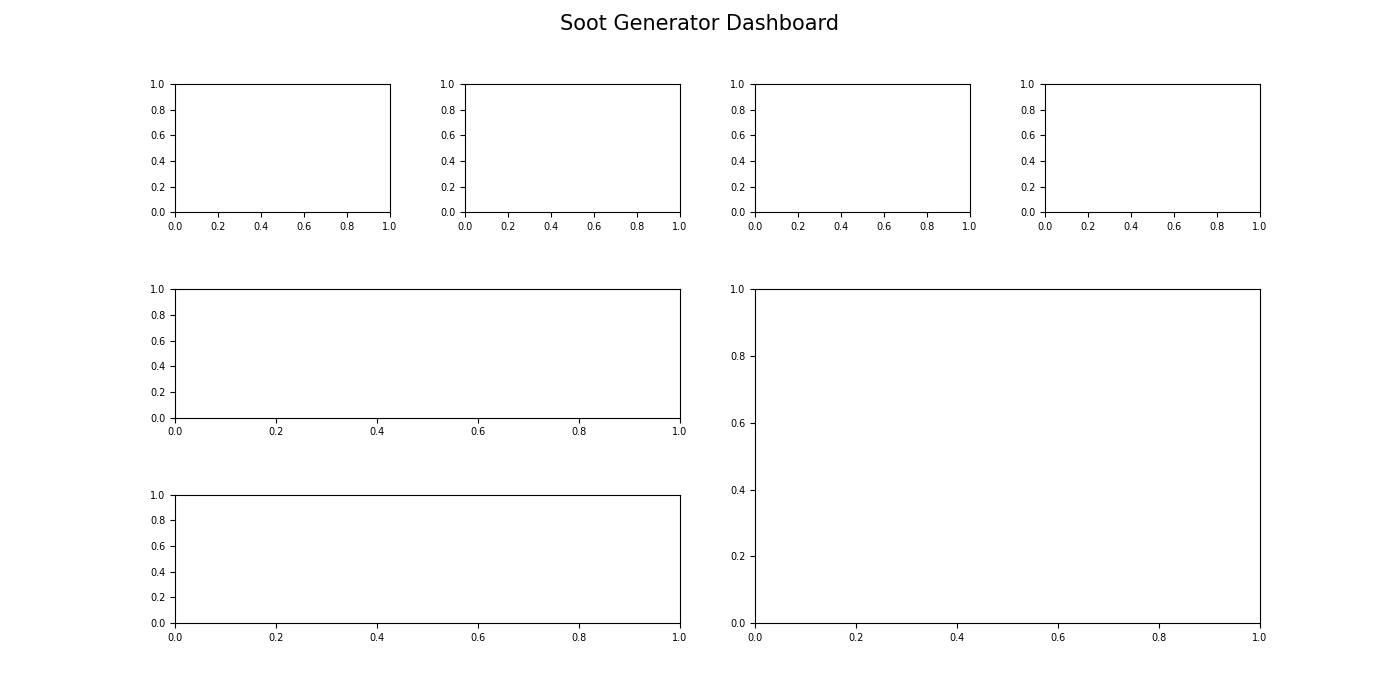

In [2]:
%matplotlib ipympl
#%matplotlib inline

#import libraries and functions
import winsound
import pandas as pd
import ipywidgets, asyncio, time
from datetime import datetime
import matplotlib.pyplot as plt
import matplotlib as mpl
import numpy as np
import matplotlib.style as mplstyle
mpl.rcParams['path.simplify_threshold'] = 1.0
mplstyle.use('fast')
import AlicatMFC as alicat
from scipy.signal import savgol_filter
numberStyle = {'description_width': "33%"}
numberstyle2  = {'description_width': "40%"}
itemLayout = ipywidgets.Layout(width = "auto",height = "30px")
def colLayout(wid):
    return ipywidgets.Layout(display = "flex",flex_flow='column',border = '1px solid black',align_items = "stretch",justify_content="flex-start",width = wid)

#create widgets
running = ipywidgets.ToggleButton(description="start", icon="play",button_style = 'danger', layout = itemLayout)
propaneSetpoint = ipywidgets.FloatSlider(description = "Prop",value = 0, min = 0, max = 0.2, step = 0.005, layout = itemLayout)
airSetpoint = ipywidgets.FloatSlider(description = "Air",value = 0, min = 0, max = 10, step = 0.1, layout = itemLayout)
xlim = ipywidgets.IntSlider(description="xlim", value=1000, min=10, max=10000, step = 200, layout = itemLayout)
ylim = ipywidgets.IntRangeSlider(description="ylim", value=[-20000,20000], min=-30000, max=100000, layout = itemLayout)

timeBase = ipywidgets.FloatText(description = "Timebase", layout = itemLayout)
ewmNum = ipywidgets.IntText(description="EWM COM",value = 40, layout = itemLayout)
tapePosition = ipywidgets.FloatText(description = "Tape Position", layout = itemLayout)
flowSetpoint = ipywidgets.FloatText(description = "Flow Setpoint", layout = itemLayout)
savePoints = ipywidgets.FloatText(description = "Save Num", value = 300, layout = itemLayout)

manualOverride = ipywidgets.Checkbox(value=True,description = "Manual Override", layout = itemLayout,indent = False)
manualPulse = ipywidgets.Checkbox(value = False, description = "pulse? (time)", layout = itemLayout,indent = False)
manualPulseTime = ipywidgets.FloatText(value = 0.5, step = 0.05,layout = ipywidgets.Layout(width ="50px" ))
manualPulseBox = ipywidgets.HBox(children = [manualPulseTime,manualPulse],layout=ipywidgets.Layout(display = "flex",flex_flow='row',align_items = "stretch",width = "auto"))
pullingFlow = ipywidgets.FloatText(description = "pulling flow (mL/M)", layout = itemLayout, value = 50)

flushSFCM = ipywidgets.FloatText(value = 0.5, layout = {'width':'50px'})
flushing = ipywidgets.Checkbox(value = False, description = "flushing? (SFCM Dil)",layout = itemLayout,indent = False)
flushBox = ipywidgets.HBox(children = [flushSFCM,flushing],layout=ipywidgets.Layout(display = "flex",flex_flow='row',align_items = "stretch",width = "auto"))

plotTime = ipywidgets.Textarea(description="plot time", layout = itemLayout)
totalTime = ipywidgets.Textarea(description="run time", layout = itemLayout)
elapsedTime = ipywidgets.Textarea(description="interval", layout = itemLayout)
interval = ipywidgets.FloatSlider(description="loop interval", value=1, min=0.001, max=3, layout = itemLayout) # zero can hang if you don't await
currentData = ipywidgets.Textarea(description="data", layout = itemLayout)

IRBc1 = ipywidgets.FloatText(description="IR Bc1", layout = itemLayout)
IRBcc = ipywidgets.FloatText(description="IR Bcc", layout = itemLayout)
Bc1EWM = ipywidgets.FloatText(description="ewm 1", layout = {'width':'45%'}, style = numberStyle)
BccEWM = ipywidgets.FloatText(description="ewm c", layout = {'width':'45%'}, style = numberStyle)
savgol1 = ipywidgets.FloatText(description="sav 1", layout = {'width':'45%'}, style = numberStyle)
savgolc = ipywidgets.FloatText(description="sav c", layout = {'width':'45%'}, style = numberStyle)
bc1 = ipywidgets.HBox(children = [Bc1EWM,savgol1], layout=ipywidgets.Layout(display = "flex",flex_flow='row',align_items = "stretch",width = "auto"))
bcc = ipywidgets.HBox(children = [BccEWM,savgolc], layout=ipywidgets.Layout(display = "flex",flex_flow='row',align_items = "stretch",width = "auto"))

showBcc = ipywidgets.Checkbox(value = True, description = "Bcc", layout = itemLayout,indent = False)
showEWM = ipywidgets.Checkbox(value = True, description = "EWM", layout = itemLayout,indent = False)
showSavgol = ipywidgets.Checkbox(value = False, description = "savgol", layout = itemLayout,indent = False)
show = ipywidgets.HBox(children = [showBcc, showEWM,showSavgol], layout=ipywidgets.Layout(display = "flex",flex_flow='row',align_items = "stretch",width = "auto"))

completions = {"start":False,"one":False,"two":False,"three":False,"four":False}

#pulse x seconds every time the bcc goes below y threshold on average over z time period
startPulseDuration = ipywidgets.FloatText(description="start p", value = 2, layout = {'width':'30%'}, style = numberstyle2)
startPulseRest = ipywidgets.FloatText(description="start rest", value = 50, layout = {'width':'30%'}, style = numberstyle2)
startPulseRuns = ipywidgets.FloatText(description="# pulses", value = 7, layout = {'width':'30%'}, style = numberstyle2)
startRow = ipywidgets.HBox(children = [startPulseDuration, startPulseRest,startPulseRuns], layout=ipywidgets.Layout(display = "flex",flex_flow='row',align_items = "stretch",width = "auto"))

startUpSleep = ipywidgets.FloatText(description="initial sleep", value = 600, layout = {'width':'45%'}, style = numberstyle2)
sleepBetweenPulses = ipywidgets.FloatText(description="sleep btw sets", value = 1500, layout = {'width':'45%'}, style = numberstyle2)
sleeps = ipywidgets.HBox(children = [startUpSleep, sleepBetweenPulses], layout=ipywidgets.Layout(display = "flex",flex_flow='row',align_items = "stretch",width = "auto"))

onePulseDuration = ipywidgets.FloatText(description="1 p", value = 1,layout = {'width':'30%'}, style = numberstyle2)
onePulseRest = ipywidgets.FloatText(description="1 rest", value = 30,layout = {'width':'30%'}, style = numberstyle2)
onePulseRuns = ipywidgets.FloatText(description="1 duration", value = 1200, layout = {'width':'30%'}, style = numberstyle2)
oneRow = ipywidgets.HBox(children = [onePulseDuration, onePulseRest,onePulseRuns], layout=ipywidgets.Layout(display = "flex",flex_flow='row',align_items = "stretch",width = "auto"))

twoPulseDuration = ipywidgets.FloatText(description="2 p", value = 1, layout = {'width':'30%'}, style = numberstyle2)
twoPulseRest = ipywidgets.FloatText(description="2 rest", value = 50, layout = {'width':'30%'}, style = numberstyle2)
twoPulseRuns = ipywidgets.FloatText(description="2 duration", value = 1200, layout = {'width':'30%'}, style = numberstyle2)
twoRow = ipywidgets.HBox(children = [twoPulseDuration, twoPulseRest,twoPulseRuns], layout=ipywidgets.Layout(display = "flex",flex_flow='row',align_items = "stretch",width = "auto"))

threePulseDuration = ipywidgets.FloatText(description="3 p", value = 1,layout = {'width':'30%'}, style = numberstyle2)
threePulseRest = ipywidgets.FloatText(description="3 rest", value = 100, layout = {'width':'30%'}, style = numberstyle2)
threePulseRuns = ipywidgets.FloatText(description="3 duration", value = 1200, layout = {'width':'30%'}, style = numberstyle2)
threeRow = ipywidgets.HBox(children = [threePulseDuration, threePulseRest,threePulseRuns], layout=ipywidgets.Layout(display = "flex",flex_flow='row',align_items = "stretch",width = "auto"))

fourPulseDuration = ipywidgets.FloatText(description="4 p", value = 0.5,layout = {'width':'30%'}, style = numberstyle2)
fourPulseRest = ipywidgets.FloatText(description="4 rest", value = 100, layout = {'width':'30%'}, style = numberstyle2)
fourPulseRuns = ipywidgets.FloatText(description="4 duration", value = 1200, layout = {'width':'30%'}, style = numberstyle2)
fourRow = ipywidgets.HBox(children = [fourPulseDuration, fourPulseRest,fourPulseRuns], layout=ipywidgets.Layout(display = "flex",flex_flow='row',align_items = "stretch",width = "auto"))

#create widget layout
col1 = ipywidgets.VBox(children = [running,propaneSetpoint,airSetpoint,xlim,ylim],layout = colLayout("20%"))
col2 = ipywidgets.VBox(children = [timeBase,ewmNum,tapePosition,flowSetpoint,savePoints],layout = colLayout("15%"))
col3 = ipywidgets.VBox(children = [manualOverride,manualPulseBox,flushBox,pullingFlow],layout = colLayout("15%"))
col4 = ipywidgets.VBox(children = [IRBc1,IRBcc,bc1,bcc,show],layout = colLayout("18%"))
col5 = ipywidgets.VBox(children = [plotTime,totalTime,elapsedTime,interval,currentData],layout = colLayout("20%"))
#automate things with col 6
#col6 = ipywidgets.VBox(children = [sleeps,startRow,oneRow,twoRow,threeRow,fourRow],layout = colLayout("30%"))
ui = ipywidgets.HBox([col1,col2,col3,col4,col5,col6],layout=ipywidgets.Layout(width = "1400px"))

tasks = dict()

#create panda dataframes
dfAeth =  pd.DataFrame([[0,0,0,0,0,0,0,0,0,0,0,0,0,0,0]],columns=['timebase', 'tape position', 'flow setpoint', 'flow total', 'sample temp', 'sample rh', 'sample dewpoint', 'uv atn1', 'uv atn2', 'ir atn1', 'ir atn2', 'ir bc1', 'ir bcc',"bc1 ewm","bcc ewm"])
dfMFC1 = pd.DataFrame(columns=['pressure','temperature','volumetric_flow','mass_flow','setpoint'])       
dfMFC2 = pd.DataFrame(columns=['pressure','temperature','volumetric_flow','mass_flow','setpoint']) 
dfSolenoid = pd.DataFrame(columns = ["timestamp","pulse duration","save status"])
dfFlush = pd.DataFrame(columns = ["timestamp","dilution flow","save status"])
dfImportant = pd.DataFrame(columns = ["timestamp", "runtime","air pressure","air temperature","propane pressure", "propane temperature","air setpoint","propane setpoint", "air mass flow","propane mass flow","sample temp","ir bc1","ir bcc","bc1 ewm","bcc ewm"])

#measure runtime and elapsed time per loop
times = [time.time()]
startTime = time.time()

pulsing = False

async def update_plots(t,recent):
    
    #get flow controller data
    alicatArray1 = alicat.getMFCData(1)
    alicatData1 = [alicatArray1]
    alicatArray2 = alicat.getMFCData(2)
    alicatData2 = [alicatArray2]

    #create and concat new MFC data into panda dataframes
    dfNewMFC1 = pd.DataFrame(alicatData1,columns=['pressure','temperature','volumetric_flow','mass_flow','setpoint'])
    dfNewMFC2 = pd.DataFrame(alicatData2,columns=['pressure','temperature','volumetric_flow','mass_flow','setpoint'])
    global dfMFC1
    dfMFC1 = pd.concat([dfMFC1,dfNewMFC1],ignore_index=True)
    global dfMFC2
    dfMFC2 = pd.concat([dfMFC2,dfNewMFC2],ignore_index=True)

    #get aeth data, and account for the possibility that it will get a 0
    aethData = alicat.getMicroAethData()
    
    if (len(aethData) != 13):
        aethData = recent
        time.sleep(1.1)
    else:
        aethData = aethData + [0,0]

    #display raw data from MA350
    currentData.value = ', '.join(str(val) for val in aethData)
    
    #concatenate the new data to the original dataframe
    aethData = [aethData]
    dfNewAeth = pd.DataFrame(aethData, columns=['timebase', 'tape position', 'flow setpoint', 'flow total', 'sample temp', 'sample rh', 'sample dewpoint', 'uv atn1', 'uv atn2', 'ir atn1', 'ir atn2', 'ir bc1', 'ir bcc',"bc1 ewm","bcc ewm"])
    global dfAeth
    dfAeth = pd.concat([dfAeth,dfNewAeth],ignore_index = True)
    
    #get exponentially weighted means and add to dataframe
    index = len(dfMFC1["setpoint"])-1
    dfAeth["bc1 ewm"] = dfAeth["ir bc1"].ewm(com = ewmNum.value).mean()
    dfAeth["bcc ewm"] = dfAeth["ir bcc"].ewm(com = ewmNum.value).mean()
    
    for ax in axes:
        axes[ax].clear()
        axes[ax].set_xlim(index+1-xlim.value,index+1)
    axes["G"].grid()
    axes["G"].set_ylim(ylim.value)
    #update each plot
    axes["A"].plot(dfMFC2["pressure"], label = "Pressure (PSIA)",color = "red")
    axes["A"].plot(dfMFC2["temperature"], label = "Temperature (C)",color = "orange")
    
    axes["B"].plot(dfMFC1["pressure"], label = "Pressure (PSIA)",color = "red")
    axes["B"].plot(dfMFC1["temperature"], label = "Temperature (C)",color = "orange")
        
    axes["C"].plot(dfAeth["sample rh"], label = "RH", color = "orange")
    axes["C"].plot(dfAeth["sample temp"], label = "Temp", color = "red")
    axes["C"].plot(dfAeth["sample dewpoint"], label = "Dewpoint", color = "blue")

    axes["D"].plot(dfAeth["uv atn1"], label = "UV ATN1", color = "pink")
    axes["D"].plot(dfAeth["uv atn2"], label = "UV ATN2", color = "red")
    axes["D"].plot(dfAeth["ir atn1"], label = "IR ATN1", color = "orange")
    axes["D"].plot(dfAeth["ir atn2"], label = "IR ATN2", color = "yellow")
    
    axes["E"].plot(dfMFC2["setpoint"], label = "Setpoint (SLPM)", color = "blue")
    axes["E"].plot(dfMFC2["mass_flow"], label = "Mass Flow Rate (SLPM)", color = "black")
    
    axes["F"].plot(dfMFC1["setpoint"], label = "Setpoint (SLPM)", color = "blue")
    axes["F"].plot(dfMFC1["mass_flow"], label = "Mass Flow Rate (SLPM)", color = "black")
    
    if showBcc.value:
        axes["G"].plot(dfAeth["ir bcc"], label = "IR BCC", color = "purple")
        axes["G"].plot(dfAeth["ir bc1"], label = "IR BC1", color = "black")
    if showEWM.value:
        axes["G"].plot(dfAeth["bcc ewm"], label = "BCC EWM", color = "darkviolet")
        axes["G"].plot(dfAeth["bc1 ewm"], label = "BC1 EWM", color = "blue")
    if dfAeth.shape[0]-1 > 50:
        w = 50
    else:
        w = dfAeth.shape[0]-1
    if showSavgol.value:
        axes["G"].plot(savgol_filter(dfAeth["bcc ewm"].to_numpy(), w, 4),label = "bcc savgol",color = "magenta")
        axes["G"].plot(savgol_filter(dfAeth["bc1 ewm"].to_numpy(), w, 4),label = "bc1 savgol",color = "cyan")
    savgolc.value = round(savgol_filter(dfAeth["bcc ewm"].to_numpy(), w, 4)[-1],1)
    savgol1.value = round(savgol_filter(dfAeth["bc1 ewm"].to_numpy(), w, 4)[-1],1)

    axes["A"].set_title("Propane MFC")
    axes["B"].set_title("Air MFC")
    axes["C"].set_title("MA350 Miscellaneous")
    axes["D"].set_title("MA350 Attenuations")
    axes["E"].set_title("Propane flow")
    axes["F"].set_title("Air Flow")
    axes["G"].set_title("IR BCC Values")

    for ax in axes:
        axes[ax].legend(loc = "upper left")
    
    startPlot = time.time()
    fig.canvas.draw()
    fig.canvas.flush_events()
    plotTime.value = str(round(time.time()-startPlot,4))

    #update time widgets
    times.append(time.time())
    elapsedTime.value = f"{t}: {round(times[-1]-times[-2],4)}"
    totalTime.value = str(round(time.time() - startTime,4))
    
    #update numerical black carbon widgets
    IRBcc.value = dfAeth.iat[index,12]
    IRBc1.value = dfAeth.iat[index,11]
    BccEWM.value = round(dfAeth.iat[index,14],1)
    Bc1EWM.value = round(dfAeth.iat[index,13],1)
    timeBase.value = dfAeth.iat[index,0]
    tapePosition.value = dfAeth.iat[index,1]
    flowSetpoint.value = dfAeth.iat[index,2]
                           
    #update DF for saving
    global dfImportant 
    dfImportant = pd.concat([dfImportant,pd.DataFrame({"timestamp": time.time(),
                       "runtime": time.time()-startTime,
                       "air pressure":alicatArray1[0],
                       "air temperature":alicatArray1[1],
                       "propane pressure":alicatArray2[0],
                       "propane temperature":alicatArray2[1],
                       "air setpoint":alicatArray1[4],
                       "propane setpoint":alicatArray2[4], 
                       "air mass flow":alicatArray1[3],
                       "propane mass flow":alicatArray2[3],
                       "sample temp":aethData[0][4],
                       "ir bc1":dfNewAeth["ir bc1"],
                       "ir bcc":dfNewAeth["ir bcc"],
                       "bc1 ewm":dfAeth.at[len(dfAeth)-1,"bc1 ewm"],
                       "bcc ewm":dfAeth.at[len(dfAeth)-1,"bcc ewm"]
                       },index = [0])],ignore_index = True)
                           
async def update_setpoints():
    alicat.setSetPoint(1,airSetpoint.value)
    alicat.setSetPoint(2,propaneSetpoint.value)
    
async def control_solenoid():
    #control solenoid via tcp connection
    if manualOverride.value == True:            
        #tell program that it has stopped pulsing
        alicat.sendTCP("stop pulsing")
        
        if manualPulse.value == True:
            
            #pulse for x time, format is 1open0.5 where 0.5 is the manual pulse direction, then turn the manualPulse value off so it only runs once
            alicat.sendTCP(f"1open{manualPulseTime.value}")
            #dfSolenoid.append({"timestamp":round(time.time(),6),"pulse duration":manualPulseTime.value,"save status":False},ignore_index = True)
            global dfSolenoid
            dfSolenoid = pd.concat([dfSolenoid,pd.DataFrame({"timestamp":round(time.time(),6),"pulse duration":manualPulseTime.value,"save status":False},index = [0])],ignore_index = True)
            manualPulse.value = False
            flushing.value = False
            
        #if flushing and this flushing status hasn't been saved yet, save
        if flushing.value == True:
            try:
                if dfFlush.at[dfFlush.shape[0]-1,"save status"] == True:
                    dfFlush.loc[dfFlush.shape[0]] = {"timestamp":round(time.time(),6),"dilution flow": flushSFCM.value, "save status":False}
            except KeyError:
                if dfFlush.shape[0]==0:
                    dfFlush.loc[dfFlush.shape[0]] = {"timestamp":round(time.time(),6),"dilution flow": flushSFCM.value,"save status":False}
        
        #if stopped flushing, check if need to save
        if flushing.value == False:
            try:
                if dfFlush.at[dfFlush.shape[0]-1, "save status"] == False:
                    dt_string = datetime.now().strftime("%d-%m-%Y %H-%M-%S")
                    df_runtime = round(float(totalTime.value),2)
                    flush_duration = round(time.time() - dfFlush.at[dfFlush.shape[0]-1,"timestamp"],2)
                    dfSave = dfImportant[-int(flush_duration):].reset_index()
                    starting_ewm = round(dfSave.at[0,"bcc ewm"],2)
                    starting_sample_temp = round(dfSave.at[0,"sample temp"],3)
                    low = round(dfSave["bcc ewm"].min(),5)
                    #convert dilution flow to SLPM
                    air_setpoint = dfFlush.at[dfFlush.shape[0]-1, "dilution flow"] * 28.317
                    propane_setpoint = round(dfSave["propane setpoint"].mean(),2)
                    pullingFlow = pullingFlow.value
                    dfSave.to_pickle(f"C:\\Users\\Kyan Shlipak\\Documents\\Solenoid Pulse DataFrames\\ Flush {dt_string} {df_runtime} {flush_duration} {starting_sample_temp} {starting_ewm} {low} {air_setpoint} {propane_setpoint} {pullingFlow}.pkl")
                    dfFlush.at[dfFlush.shape[0]-1,"save status"] = True
            except KeyError:
                #the dataframe is empty and we aren't flushing, nothing to be done
                pass
    
        #check if solenoid pulse dataframe needs to be saved                   
        for index,row in dfSolenoid.iterrows():
            
            #save if it hasn't been saved and enough time has passed
            if (row["save status"] == False) and ((time.time() -row["timestamp"]) > savePoints.value):
                dt_string = datetime.now().strftime("%d-%m-%Y %H-%M-%S")
                dfSave = dfImportant[int(-savePoints.value-100):].reset_index()
                df_runtime = round(float(totalTime.value),2)
                pulse_duration = dfSolenoid.at[dfSolenoid.shape[0]-1,"pulse duration"]
                starting_ewm = round(dfSave.at[0,"bcc ewm"],2)
                starting_sample_temp = round(dfSave.at[0,"sample temp"],3)
                peak = round(dfSave["bcc ewm"].max(),5)
                air_setpoint = round(dfSave["air setpoint"].mean(),2)
                propane_setpoint = round(dfSave["propane setpoint"].mean(),2)
                pullingFlow = pullingFlow.value
                dfSave.to_pickle(f"C:\\Users\\Kyan Shlipak\\Documents\\Solenoid Pulse DataFrames\\ Pulse {dt_string} {df_runtime} {pulse_duration} {starting_sample_temp} {starting_ewm} {peak} {air_setpoint} {propane_setpoint} {pullingFlow}.pkl")
                dfSolenoid.at[index,"save status"] = True
                
                           
    elif manualOverride.value == False:
          pass
          #startup, sleep, one, sleep, two, sleep, three, sleep
          #startingThing = pulse duration * 180 / pulse rest, 5 times, 20 seconds rest
            
#         if dfAeth.shape[0]-1 > 50:
#             w = 50
#         else:
#             w = dfAeth.shape[0]-1
            
#         #set pulse duration
#         if goalConcentration.value > 25000:
#             beep = 1 + (goalConcentration.value - 25000)/40000
#         else:
#             beep = 1 - (25000-goalConcentration.value)/50000
            
#         #make timeout time longer for a smaller goal concentration 
#         savgolMean = savgol_filter(dfAeth["bcc ewm"].to_numpy(), w, 4)[-27:-6].mean()

#         timeout = 50 + (50000-goalConcentration.value)/1400
        
#         #max timeout while trying to reach a concentration
#         maxTimeout = 80 - goalConcentration.value**0.8 / 50
        
#         #timeout while trying to reach a concentration
#         increaseTimeout = maxTimeout - (goalConcentration.value - savgolMean)/4000
        
#         #update concentrations list
#         try:
#             lastConcentration = concentrations.at[len(concentrations.index)-1,"Goal Concentration"]
#         except KeyError:
#             lastConcentration = 0
#         if goalConcentration.value != lastConcentration:
#             newType = ''
#             if goalConcentration.value > savgolMean: 
#                 newType = 'Bigger'
#             else: 
#                 newType = 'Smaller'
#             concentrations.loc[len(concentrations.index)] = [goalConcentration.value,False,newType]
            
#         #start pulsing for x time on and y time off, format is 1openx,y. If already pulsing, the command will be ignored
#         if len(autoPulses) == 0 and savgolc.value < (goalConcentration.value - 500):
#             winsound.Beep(700,200)
#             print(beep)
#             autoPulses.append(time.time())
            
#         #get line of best fit for previous 40 values
#         xfit = list(range(30))
#         m,b = np.polyfit(xfit,savgol_filter(dfAeth["bcc ewm"].to_numpy(), 30, 4)[-37:-7],1)
        
#         if concentrations.at[len(concentrations.index)-1,"Reached"] == False and concentrations.at[len(concentrations.index)-1,"Type"] == "Bigger":
#             #goal concentration has not been reached, get there.
                    
#             #concentration has not been reached, keep pulsing
#             recentPulses = 0
#             for pulse in autoPulses:
#                 if time.time() - pulse < 300:
#                     recentPulses = recentPulses + 1
                    
#             #concentration has been reached, change value
#             if savgolMean + m * slopeWeight.value>= goalConcentration.value * 0.96:
#                 concentrations.at[len(concentrations.index)-1,"Reached"] = True
#                 autoPulses.append(time.time()+30)
#             elif time.time() - autoPulses[-1] > (increaseTimeout) and savgolMean < goalConcentration.value*(0.96):
#                 winsound.Beep(700,200)
#                 print(beep)
#                 autoPulses.append(time.time())
#         elif concentrations.at[len(concentrations.index)-1,"Reached"] == False and concentrations.at[len(concentrations.index)-1,"Type"] == "Smaller":
#             #goal concentration not reached, lower to there
#             if savgolMean <= goalConcentration.value * 1.05:
#                 concentrations.at[len(concentrations.index)-1,"Reached"] = True
        
#         if concentrations.at[len(concentrations.index)-1,"Reached"] == True:
#             #goal concentration has been reached
#             if (time.time()-autoPulses[-1]) > timeout and (savgolMean + m*slopeWeight.value) < (goalConcentration.value*0.96-300):
#                 winsound.Beep(700,200)
#                 print(beep)
#                 autoPulses.append(time.time())
            
async def safety_check():
    x = []
    try:
        i = 0
        for index,row in dfMFC1[-8:].iterrows():
            if row["mass_flow"] < 0.7*row["setpoint"] and row["setpoint"] >= 1:
                x.append(True)
            else:
                x.append(False)
        if dfMFC2.at[len(dfMFC2)-1, "mass_flow"] > 0.005:
            x.append(True)
        else:
            x.append(False)
    except KeyError:
        pass
    
    #check if the mass flow has been to low for 20 seconds, error alarm
    if all(x):
        winsound.Beep(3000,200)
        
        
async def do_loop():
    t = 0
    while running.value:
        recent = dfAeth.iloc[-1].tolist()
        asyncio.get_event_loop().create_task(update_plots(t,recent))
        asyncio.get_event_loop().create_task(update_setpoints())
        asyncio.get_event_loop().create_task(control_solenoid())
        asyncio.get_event_loop().create_task(safety_check())
        t += 1
        await asyncio.sleep(0.993)

#stop or start main loop according to the start/stop button
def on_running_changed(*change):
    task = tasks.pop("do_loop", None)
    elapsedTime.value = f"maybe stopping {task}..."
   
    if task:
        task.cancel()
        alicat.closePorts()
        alicat.endTCP()

    if running.value:
        elapsedTime.value = "starting..."
        alicat.openPorts("COM3","COM4","COM5")
        try:
            alicat.endTCP()
        except NameError:
            pass
        time.sleep(0.1)
        alicat.startTCP()
        tasks["do_loop"] = asyncio.get_event_loop().create_task(do_loop())

#customize plot font sizes
plt.rc('axes',titlesize=10)
plt.rc('xtick',labelsize=7)
plt.rc('ytick',labelsize=7)
plt.rc('legend',fontsize = 8)
plt.rc('figure',titlesize = 15)

#create "mosaic" customizing grid layout. Semicolons separate rows
fig,axes = plt.subplot_mosaic("ABCD;EEGG;FFGG")
fig.set_size_inches(14,7)
fig.suptitle("Soot Generator Dashboard")
plt.tight_layout
plt.subplots_adjust(wspace =0.35,hspace = 0.6)
plt.ion()
fig.canvas.draw()

#observe stop/start button
running.observe(on_running_changed, "value")

#display UI (widget grid)
ui

In [2]:
print(dfSolenoid)

Empty DataFrame
Columns: [timestamp, pulse duration, save status]
Index: []


In [ ]:
print(time.time()-dfSolenoid.at[dfSolenoid.shape[0]-1,'timestamp'])

In [3]:
concentrations


,Goal Concentration,Reached,Type
0,20000,False,Bigger


In [5]:
print(time.time() - autoPulses[-1])

29.826858282089233


In [4]:
savgolMean = savgol_filter(dfAeth["bcc ewm"].to_numpy(), 50, 4)[-25:-3].mean()
xfit = list(range(40))
m,b = np.polyfit(xfit,savgol_filter(dfAeth["bcc ewm"].to_numpy(), 40, 4)[-45:-5],1)
print(savgolMean + m*slopeWeight.value)

13094.101622465068


[51, 74, 96, 118, 140, 162, 184, 206, 229, 251, 273, 295]

0.9
0.9
0.9
0.9
0.9
0.9


1.125
1.125
1.125
1.125
1.125
1.125
1.125


[142, 189, 237, 284, 333, 407, 486, 566, 651, 755]
4536.892625


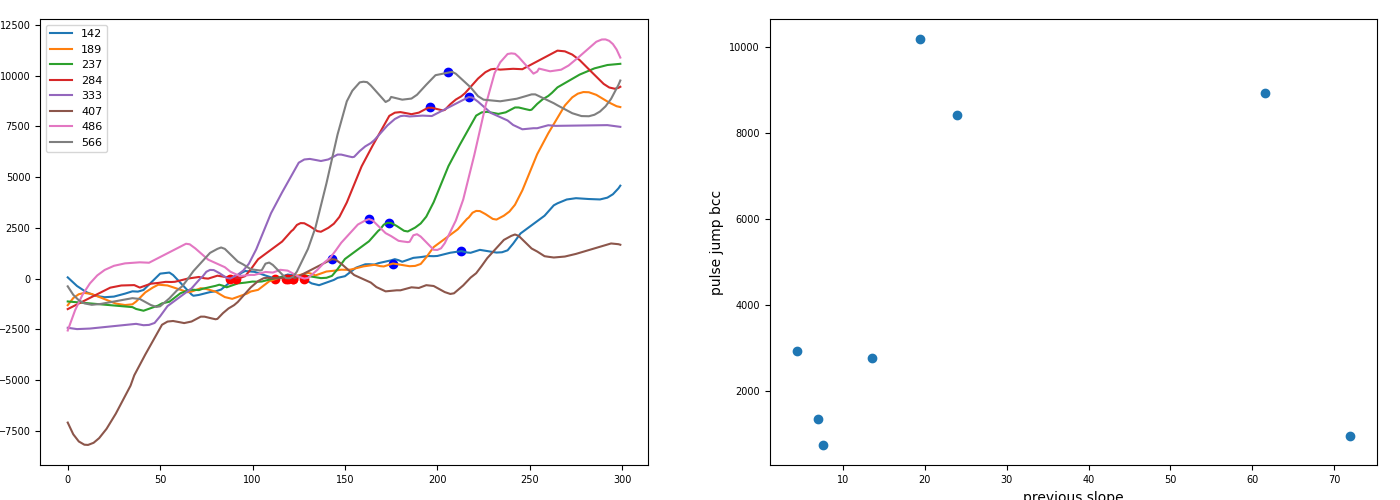

In [26]:
#plot all flush chambers

%matplotlib ipympl
import numpy as np
import matplotlib.pyplot as plt
from scipy.signal import argrelextrema
from scipy.signal import find_peaks
from scipy.signal import savgol_filter

fig2,(ax3, ax4) = plt.subplots(1,2)
#fig2.clear()
fig2.set_size_inches(14,5)
plt.tight_layout()
plt.subplots_adjust(hspace = 0.2,wspace = 0.2)
plt.ion()
fig2.canvas.draw()

pulseIndexes = []
for i in autoPulses:
    if int(i-times[1]-1) > 100 and times[-1] > int(i-times[1]-1) + 200:
        pulseIndexes.append(int(i-times[1]-1))
print(pulseIndexes)

def getPeaks(yhat):
    #find initial peaks
    peaks,t = find_peaks(yhat[:220], distance=60)
    realPeaks = []
            
    #sort out peaks from before the pulse
    ipeaks = []
    for i in range(len(peaks)):
        if peaks[i] > 120 and peaks[i] < 220:
            ipeaks.append(peaks[i])
        if len(ipeaks) > 1:
            if yhat[ipeaks[0]] > yhat[ipeaks[1]]:
                del ipeaks[1]
            else:
                    del ipeaks[0]
    return(ipeaks)

def plotPulseSamePlot(pulseIndexes):
    dis = []
    slopes = []
    colors = ["red","orange","green","blue","purple","magenta","grey","black","brown"]
    for index in pulseIndexes:
        bccvals = dfAeth["bcc ewm"][index-100:index+200].to_numpy()
        if len(bccvals) >= 300:
            yhat = savgol_filter(bccvals, 70, 4)

#             #have them all start at the same y 
            starty = yhat[0]
            minima = argrelextrema(yhat[0:130], np.less)
            minimay = yhat[0:130][argrelextrema(yhat[0:130], np.less)]
            for i in range(len(yhat)):
                yhat[i] = round(yhat[i] - minimay[-1],3)
                bccvals[i] = round(bccvals[i] -  minimay[-1],3)
            peaks = getPeaks(yhat)
            ax3.plot(peaks[0], yhat[peaks[0]], "o",color ="blue")
            
            #plot line of best fit for beginning
            xfit = list(range(130))
            m,b = np.polyfit(xfit,yhat[:130],1)
            yfit = list((val*m+b) for val in xfit)
            #ax3.plot(xfit,yfit,color = colors[path%len(colors)])
            
            #find and plot minima
            minima = argrelextrema(yhat[0:130], np.less)
            minimay = yhat[0:130][argrelextrema(yhat[0:130], np.less)]
            ax3.plot(minima[0][-1],minimay[-1],'o',color = 'red')
            
            #calculate average jump
            dis.append(yhat[peaks[0]] - minimay[-1])
            slopes.append(m)
            #plt.plot(bccvals)
            ax3.plot(yhat,label = str(index))
            
    print(np.mean(dis))
    ax4.scatter(slopes,dis)
    ax4.set_xlabel('previous slope')
    ax4.set_ylabel('pulse jump bcc')
fig2.canvas.draw()
        
plotPulseSamePlot(pulseIndexes)
ax3.legend(loc="upper left")
# xs = list(range(-1000,2000))
# ys = []
# for i in xs:
#     ys.append(12000*1.125**(-(i+100)/100))
# ax3.plot(xs, ys)

In [18]:
%matplotlib ipympl
fig.canvas.draw()
fig.canvas.flush_events()